# predictive uncertainty visualization

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [61]:
from matplotlib.ticker import FuncFormatter 
import matplotlib.ticker as ticker
mpl.rcParams['font.size'] = 16
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 14

## Violin plot

In [4]:
# import the annual loads
file_dates = ['20220118_full', '20220123', '20220125', '20220126', '20220128', '20220129', '20220130', '20220201', '20220203', '20220204']
ind_results = [26, 12, 24, 8, 12, 12, 8, 11, 9, 7]
fpaths = [f'../../output/work_run_{fd}/' for fd in file_dates]
fns = [f'126001A.{ind_result}.obs.csv' for ind_result in ind_results]
fn_figs = '../../output/figs/'
k = 0
file_date, fpath, fn = file_dates[k], fpaths[k], fns[k]
fn_meas = '126001A.base.obs.csv'
fn_total_unc = 'total_uncertainty.csv'
log_load = True

In [105]:
df = pd.read_csv(fpath + fn, index_col = 'real_name')
df_total_unc = pd.read_csv(fpath + fn_total_unc, index_col = 'real_name')
# select results of which the pbias is with 15%
# df = df[(df.din_pbias < 15) & (df.din_pbias > -15)]
df_meas = pd.read_csv(fpath + fn_meas, index_col = 'real_name')
if log_load:
    df_meas.loc[:, 'din_2009':] = 10**(df_meas.loc[:, 'din_2009':])
    df.loc[:, 'din_2009':] = 10**(df.loc[:, 'din_2009':])

df['average'] = df.loc[:, 'din_2009':'din_2017'].mean(axis=1).values
df_meas['average'] = df_meas.loc[:, 'din_2009':'din_2017'].mean(axis=1).values
df_total_unc['average'] = df_total_unc.loc[:, 'din_2009':'din_2017'].mean(axis=1).values

# obs data
obs_annual = [52.093, 99.478, 44.064, 57.936, 53.449, 21.858, 38.561, 51.843, 14.176]
obs_annual.append(np.round(np.mean(obs_annual), 2))
obs_df = pd.DataFrame(data=obs_annual, index = [*np.arange(2009, 2018), 'average'], columns=['Annual loads'])

In [106]:
# reorganize the dataframe for plotting
df_plot = pd.DataFrame(data = df.values[:, 1:].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df.shape[0], 0).T
df_plot['year'] = year_col
df_plot['type'] = 'Parameter uncertainty'

df_meas_plot = pd.DataFrame(data = df_meas.values[:, 1:].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df_meas.shape[0], 0).T
df_meas_plot['year'] = year_col
df_meas_plot['type'] = 'Measurement realization'

df_total_unc_plot = pd.DataFrame(data = df_total_unc.values[:, :].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df_total_unc.shape[0], 0).T
df_total_unc_plot['year'] = year_col
df_total_unc_plot['type'] = 'Total Uncertainty'

df_plot = pd.concat([df_meas_plot, df_plot])
df_total_unc_plot = pd.concat([df_meas_plot, df_total_unc_plot])
df_total_unc_plot = df_total_unc_plot.reset_index(drop=True)

df_plot.reset_index().tail()

,index,Annual loads,year,type
1925,925,61.297703,2018,Parameter uncertainty
1926,926,58.993120,2018,Parameter uncertainty
1927,927,61.952209,2018,Parameter uncertainty
1928,928,51.913722,2018,Parameter uncertainty
1929,929,63.338739,2018,Parameter uncertainty


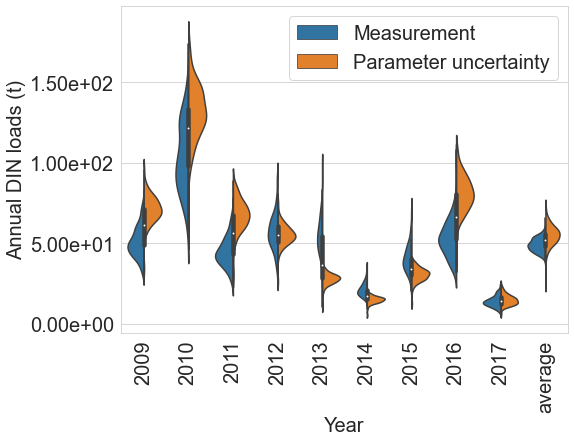

In [107]:
# Plot the uncertainty of annual loads
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='year', y='Annual loads', data=df_plot, hue='type', split=True);
ax.legend(handles=ax.legend_.legendHandles, labels=['Measurement', 'Parameter uncertainty'])
# obs_df.plot(y=[0], linewidth=0, ax=ax, marker='d', markersize=5, color='r', legend=['Obs']);
ax.set_xticklabels([*np.arange(2009, 2018), 'average'], rotation=90);
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.set_xlabel('Year')
ax.set_ylabel('Annual DIN loads (t)')
plt.savefig(f'{fn_figs}parameter_uncertainty_{file_date}.png', dpi=300, format='png')

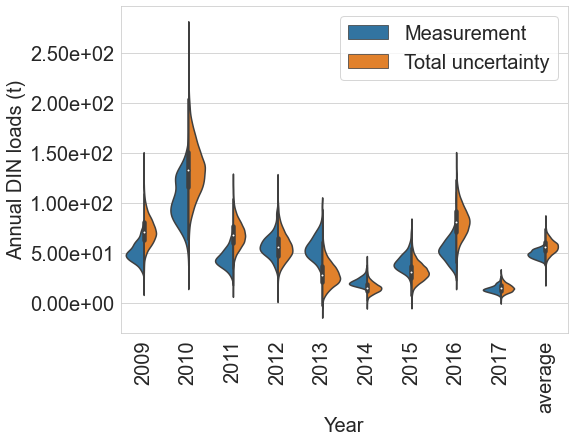

In [108]:
# Plot the uncertainty of annual loads
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='year', y='Annual loads', data=df_total_unc_plot, hue='type', split=True);
ax.legend(handles=ax.legend_.legendHandles, labels=['Measurement', 'Total uncertainty'])
# obs_df.plot(y=[0], linewidth=0, ax=ax, marker='d', markersize=5, color='r', legend=['Obs']);
ax.set_xticklabels([*np.arange(2009, 2018), 'average'], rotation=90);
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.set_xlabel('Year')
ax.set_ylabel('Annual DIN loads (t)')
plt.savefig(f'{fn_figs}total_uncertainty_{file_date}.png', dpi=300, format='png')

## Plot metrics

In [5]:
# read files
num_pars = ['13', '12', '11', '10', '9', '7', '5', '4', '3', '1']
cols = ['Coverage ratio', 'Uncertainty overlap', 'Width index']
metric_pars_unc = pd.DataFrame(columns = cols, index=num_pars)
metric_total_unc = pd.DataFrame(columns = cols, index=num_pars)
objective_functions = pd.DataFrame()

k = 0
for fp in fpaths:
    metric_pars_unc.loc[num_pars[k], :] = pd.read_csv(fp +'metric_param_unc.csv', index_col='Unnamed: 0').values
    metric_total_unc.loc[num_pars[k], :] = pd.read_csv(fp +'metric_total_unc.csv', index_col='Unnamed: 0').values
    df_temp = pd.read_csv(fp +'objective_functions.csv', index_col='Unnamed: 0')
    df_temp['num_pars'] = num_pars[k]
    objective_functions = pd.concat([objective_functions, df_temp])
    
    k += 1
# cols = metric_dict[file_dates[k-1]].columns
objective_functions = objective_functions.reset_index(drop=True).reset_index()
objective_functions['PBIAS'] = objective_functions['PBIAS'].values / 100

In [49]:
metric_total_unc

,Coverage ratio,Uncertainty overlap,Width index
13,0.777778,0.753883,2.18747
12,1,0.765556,2.19161
11,0.777778,0.723356,2.1279
10,0.555556,0.588103,2.66592
9,0.555556,0.595556,2.80171
7,0.555556,0.602222,2.97831
5,0.555556,0.551066,2.76077
4,0.555556,0.518889,2.17516
3,0.444444,0.588889,1.8955
1,0.444444,0.546577,1.75711


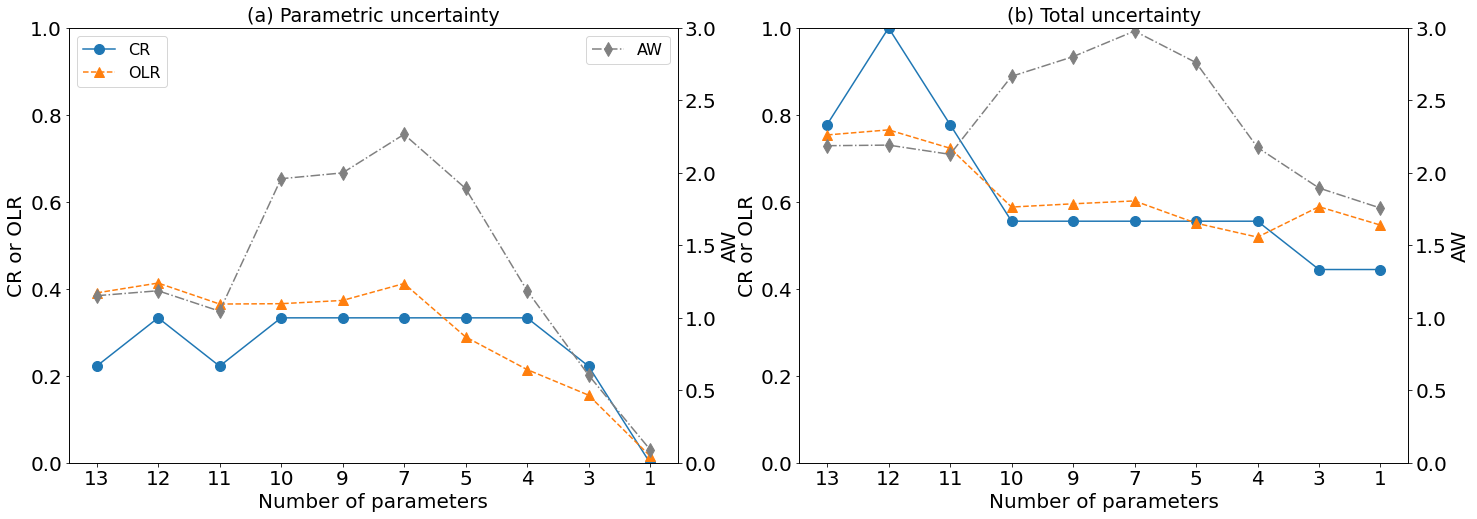

In [62]:
# plotting metrics
ylabs = ['(a) Parametric uncertainty', '(b) Total uncertainty']
fig, axes = plt.subplots(1, 2, figsize=(12*2, 8*1), sharey=False)
ax_twins = [axes[0].twinx(), axes[1].twinx()]
cols = metric_pars_unc.columns
unc_ALL = [metric_pars_unc, metric_total_unc]
for ii in range(2):
    unc_ALL[ii][cols[0]].plot(ax=axes[ii], marker='o', legend=False, ms=10)
    unc_ALL[ii][cols[1]].plot(ax=axes[ii], marker='^', legend=False, ms=10, ls='--')
    unc_ALL[ii][cols[2]].plot(ax=ax_twins[ii], marker='d', legend=False, color='grey', ls='-.', ms=10)
    axes[ii].set_xlabel('Number of parameters')
#     axes[ii].set_xticks(np.arange(12, 0, -1))
    axes[ii].xaxis.set_major_locator(ticker.FixedLocator(np.arange(10)))
    axes[ii].set_xticklabels(num_pars)
    axes[ii].set_title(ylabs[ii])
    axes[ii].set_ylabel('CR or OLR')
    ax_twins[ii].set_ylabel('AW')
    ax_twins[ii].set_ylim(0, 3)
    axes[ii].set_ylim(0, 1)

# axesAll = axes[0] + ax1
axes[0].legend(['CR', 'OLR'], loc='upper left', fontsize=16)
ax_twins[0].legend(['AW'], loc='upper right', fontsize=16)
plt.savefig(f'{fn_figs}metric_param_unc_doubleY.png', dpi=300, format='png')

In [63]:
objective_functions

,index,NSE,PBIAS,R2,num_pars
0,0,0.438697,-0.091657,0.733279,13
1,1,0.005733,0.232379,0.564168,13
2,2,0.004062,0.088017,0.528585,13
3,3,0.489357,0.122324,0.784864,13
4,4,0.330634,-0.132818,0.680451,13
...,...,...,...,...,...
983,983,0.835599,0.005721,0.883028,1
984,984,0.217543,0.101562,0.665484,1
985,985,0.785324,0.062628,0.865479,1
986,986,-0.295155,0.255925,0.640290,1


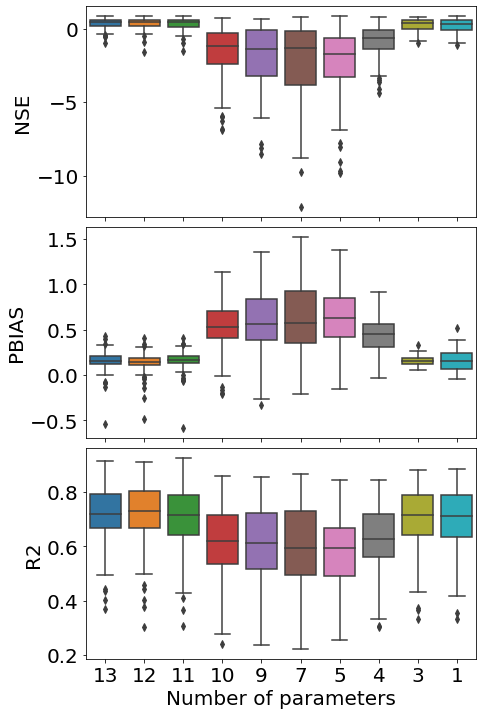

In [86]:
# Plot objective functions
import seaborn as sns
fig, axes = plt.subplots(3, 1, figsize=(7*1, 4*3), sharex=True)
metrics = ['NSE', 'PBIAS', 'R2']
for ii in range(3):
    sns.boxplot(data=objective_functions,  x='num_pars', y=metrics[ii], ax=axes[ii])
    axes[ii].set_xlabel('')
    
axes[2].set_xlabel('Number of parameters')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.savefig(f'{fn_figs}objective_functions_subplots.png', format='png', dpi=300)

In [94]:
cols_obj = ['NSE_mean', 'PBIAS_mean', 'R2_mean', 'NSE_std', 'PBIAS_std', 'R2_std', 'NSE_best', 'PBIAS_best', 'R2_best', 'NSE_worst', 'PBIAS_worst', 'R2_worst']
df_summary = pd.DataFrame(index=num_pars, columns=cols_obj)
for ii in num_pars:
    df_summary.loc[ii, cols_obj[0:3]] = objective_functions[objective_functions['num_pars'] == ii].mean()[1:-1].values
    df_summary.loc[ii, cols_obj[3:6]] = objective_functions[objective_functions['num_pars'] == ii].std()[1:].values
    df_summary.loc[ii, cols_obj[6:9]] = objective_functions[objective_functions['num_pars'] == ii].max()[1:-1].values
    df_summary.loc[ii, cols_obj[7]] = objective_functions[objective_functions['num_pars'] == ii]['PBIAS'].abs().min()
    df_summary.loc[ii, cols_obj[9:12]] = objective_functions[objective_functions['num_pars'] == ii].min()[1:-1].values
    df_summary.loc[ii, cols_obj[10]] = objective_functions[objective_functions['num_pars'] == ii]['PBIAS'].abs().max()
cols_obj_order = ['NSE_mean', 'NSE_std', 'NSE_best','NSE_worst', 'PBIAS_mean', 'PBIAS_std', 'PBIAS_best','PBIAS_worst', 'R2_mean', 'R2_std', 'R2_best', 'R2_worst']
df_summary[cols_obj_order].to_csv(f'{fn_figs}objective_summary.csv')

## Plot Parameter metrics

In [107]:
# read files
fn_figs = '../../output/figs/'
num_pars = ['13', '12', '11', '10', '9', '7', '5', '4', '3', '1']
par_orders = ['goEMC', 'DRF', 'fEMC', 'cEMC', 'oEMC', 'DWC', 'gfEMC', 'goDWC', 'fDWC', 'cDWC', 'DRP', 'gfDWC', 'oDWC']
par_orders.reverse()
par_iqr = pd.read_csv(fn_figs + 'parameter_iqr.csv')[par_orders].round(2)
par_iqr_change = ((par_iqr - par_iqr.iloc[0].values) / par_iqr.iloc[0].values).round(2)
par_mad = pd.read_csv(fn_figs + 'parameter_quantile25.csv')[par_orders].round(2)
par_range = pd.read_csv(fn_figs + 'parameter_quantile75.csv')[par_orders].round(2)
par_metrics = [par_iqr, par_mad, par_range, par_iqr_change]
metrics_names = ['IQR', 'Q25', 'Q75', '% of IQR']

In [106]:
par_iqr_change

,oDWC,gfDWC,DRP,cDWC,fDWC,goDWC,gfEMC,DWC,oEMC,cEMC,fEMC,DRF,goEMC
0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,-1.0,0.21,0.0,-0.02,-0.03,0.17,0.0,0.0,0.0,0.0,0.0,0.05,0.0
2,-1.0,-1.00,-0.5,0.02,-0.06,-0.33,0.0,0.0,0.0,-1.0,0.0,-0.19,0.0
3,-1.0,-1.00,-1.0,0.67,0.51,5.00,1.0,0.0,3.5,3.0,2.0,-0.33,3.0
4,-1.0,-1.00,-1.0,-1.00,0.51,4.00,1.0,0.5,3.0,3.0,1.0,-0.24,3.0
5,-1.0,-1.00,-1.0,-1.00,-1.00,-1.00,1.0,0.5,3.0,3.0,2.0,-0.19,3.0
6,-1.0,-1.00,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,7.0,4.0,2.0,-0.29,2.0
7,-1.0,-1.00,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,2.0,1.0,-0.48,2.0
8,-1.0,-1.00,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-0.67,-1.0
9,-1.0,-1.00,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0


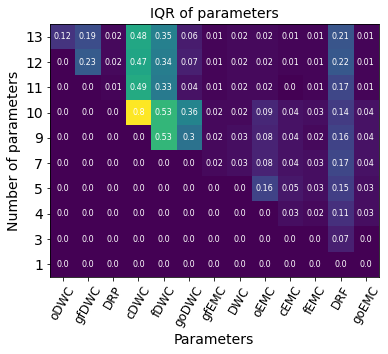

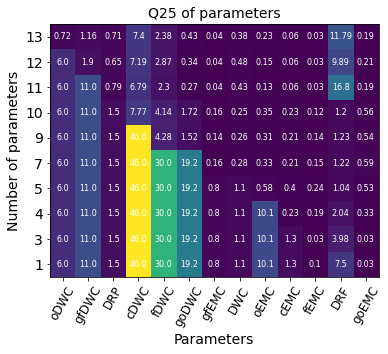

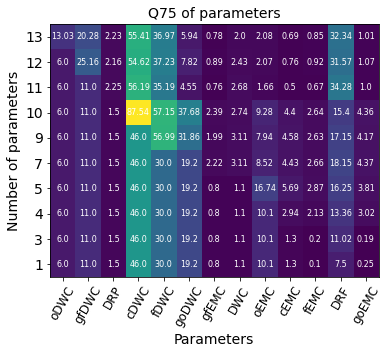

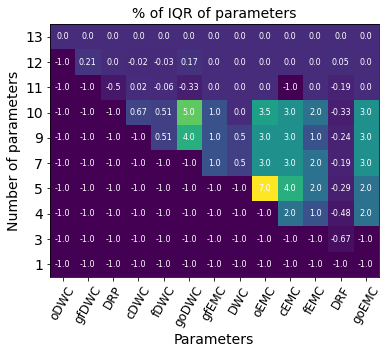

In [109]:
for ii in range(len(metrics_names)):
    fig, ax = plt.subplots(figsize=(6, 5))
    values = par_metrics[ii].values
    im = ax.imshow(values)
    # Show all ticks and label them with the respective list entries
    ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(10)))
    ax.set_yticklabels(num_pars,fontsize=14)
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(13)))
    ax.set_xticklabels(par_orders, rotation=60, fontsize=12)
    ax.set_ylabel('Number of parameters',fontsize=14)
    ax.set_xlabel('Parameters',fontsize=14)
    # Loop over data dimensions and create text annotations.
    for i in range(len(num_pars)):
        for j in range(len(par_orders)):
            text = ax.text(j, i, values[i, j],
                           ha="center", va="center", color="w", fontsize=8)

    ax.set_title(f'{metrics_names[ii]} of parameters', fontsize=14)
    fig.tight_layout()
    plt.savefig(f'{fn_figs}{metrics_names[ii]}_parameters.png', format='png', dpi=300)